Hunter Bennett  
Glass Lab  
Created 180111 | Last updated 180111  
____________  
This notebook explores our rna sequencing data for the three strains of mice. This notebook is interested in identifying differential gene expression as induced by the diet across the strains. This relaxes some of the stringencies from prior analyses and should give us more results compares to prior work. See prior notebooks (171208_RNASeq_Strains.ipynb) for assessing the inter-sample variability using MDS plots, heatmaps, etc.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
# %load_ext rpy2.ipython

In [2]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/RNA/'}

# define output directory
outdir = '/home/h1bennet/LXR/results/180312_LXRaKO_CCl4/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE1_CC1B_JSS_l20171006_GGTAGC",
"mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE2_CC1C_JSS_l20171006_ATGAGC",
"mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE3_CC1D_JSS_l20171006_ATTCCT",
"mouse_C57Bl6_M_KupfferTim4Pos_RNA_polyA_CCl4sixWks_JSSTDTD1_CC1B_JSS_l20171006_GTTTCG",
"mouse_C57Bl6_M_KupfferTim4Pos_RNA_polyA_CCl4sixWks_JSSTDTD2_CC1C_JSS_l20171006_CGTACG",
"mouse_C57Bl6_M_KupfferTim4Pos_RNA_polyA_CCl4sixWks_JSSTDTD3_CC1D_JSS_l20171006_CATTTT",
"mouse_LXRaKO_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE4_LXR703_JSS_l20171006_CAAAAG",
"mouse_LXRaKO_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE5_LXR705_JSS_l20171006_CAACTA",
"mouse_LXRaKO_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE6_LXR706_JSS_l20171006_CACCGG",
"mouse_LXRaKO_M_KupfferTim4Pos_RNA_polyA_CCl4sixWks_JSSTDTD4_LXR703_JSS_l20171006_CCAACA",
"mouse_LXRaKO_M_KupfferTim4Pos_RNA_polyA_CCl4sixWks_JSSTDTD5_LXR705_JSS_l20171006_GACGAC",
"mouse_LXRaKO_M_KupfferTim4Pos_RNA_polyA_CCl4sixWks_JSSTDTD6_LXR706_JSS_l20171006_TAATCG",
"LXRaKO_M_KupfferTim4Neg_RNA_polyA_NoTx_LX11pool_JSS_TDT_20170916",
"LXRaKO_M_KupfferTim4Neg_RNA_polyA_NoTx_LX6pool_JSS_TDT_20170916",
"LXRaKO_M_KupfferTim4Pos_RNA_polyA_NoTx_LX11pool_JSS_TDT_20170916",
"LXRaKO_M_KupfferTim4Pos_RNA_polyA_NoTx_LX6pool_JSS_TDT_20170916",
"NCoRWT_Tim4PosKupffer_RNA_polyA_ControlDiet_6week_LN246cM_JSS_TDT_17_01_13",
"NCoRWT_Tim4PosKupffer_RNA_polyA_ControlDiet_6week_LN247aM_JSS_TDT_17_01_13"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [3]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2]
samplesDF['genotype'] = ['C57BL6', 'C57BL6', 'C57BL6', 'C57BL6', 'C57BL6', 'C57BL6', 'LXRaKO', 'LXRaKO',
                         'LXRaKO', 'LXRaKO', 'LXRaKO', 'LXRaKO', 'LXRaKO', 'LXRaKO', 'LXRaKO', 'LXRaKO',
                         'C57BL6', 'C57BL6']
samplesDF['cells'] = ['Tim4Neg', 'Tim4Neg', 'Tim4Neg', 'Tim4Pos', 'Tim4Pos', 'Tim4Pos', 'Tim4Neg', 'Tim4Neg',
                      'Tim4Neg', 'Tim4Pos', 'Tim4Pos', 'Tim4Pos', 'Tim4Neg', 'Tim4Neg', 'Tim4Pos', 'Tim4Pos',
                      'Tim4Pos', 'Tim4Pos']
samplesDF['diet'] = ['CCl4', 'CCl4', 'CCl4', 'CCl4', 'CCl4', 'CCl4', 'CCl4', 'CCl4', 'CCl4', 'CCl4',
                     'CCl4', 'CCl4', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control']
samplesDF['cage'] = ['CC1B', 'CC1C', 'CC1D', 'CC1B', 'CC1C', 'CC1D',
                     'LXR703', 'LXR705', 'LXR706', 'LXR703', 'LXR705', 'LXR706',
                     'LX11', 'LX6', 'LX11', 'LX6', 'LN246cM', 'LN247aM']
samplesDF['group'] = samplesDF['genotype'] + '_' + samplesDF['cells'] + '_' + samplesDF['diet']
samplesDF['group_diet'] = samplesDF['genotype'] + '_' + samplesDF['diet']
samplesDF['group_unique'] = samplesDF['group'] + '_' + samplesDF['cage']

In [4]:
# set colors for the samples
color_dict = {'C57BL6_Tim4Pos_CCl4': '#e31a1c',
              'C57BL6_Tim4Neg_CCl4': '#fb9a99',
              'LXRaKO_Tim4Pos_CCl4': '#33a02c',
              'LXRaKO_Tim4Neg_CCl4': '#b2df8a',
              'LXRaKO_Tim4Pos_Control': '#01665e',
              'LXRaKO_Tim4Neg_Control': '#80cdc1',
              'C57BL6_Tim4Pos_Control': '#ff7f00',
              'C57BL6_Tim4Neg_Control': '#fdbf6f'}

samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'ccl4_samples.txt', sep='\t')

Set some user defined functions

In [5]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = tpm.copy(deep=True)
    if not ((tissue=='') & (strain=='')):
        tmp_df = hbUtils.df_col_subset(tmp_df, strain + '.*' + tissue)
    # tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]{1,4}[0-9]+[a-zA-Z]{1,4})[_-]',
    #                                                              flags=re.IGNORECASE, expand=False)
    print(tmp_df.shape)
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)
        
def makeHub(samplelist, name, genome, plotoption=None, force=True):
    '''Takes a list of samples and runs the homer makeMultiWigHub.pl command with them
    '''
    mwcall = ['makeMultiWigHub.pl', name, genome]
    if plotoption != None:
        mwcall.extend(['-'+plotoption])
    mwcall.extend(['-url', 'http://homer.ucsd.edu/hubs/',
            '-webdir', '/homer_data/www/html/hubs'])
    if force:
        mwcall.extend(['-force'])
    mwcall.extend(['-d'])
    mwcall.extend(list(samplelist))
    subprocess.call(mwcall)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def process_rpkm(rpkm, conv_tpm = False):
    rpkm = rpkm.loc[rpkm.Length >= 200, :]

    # Create column for gene
    rpkm.loc[:, 'Gene'] = pd.Series([x.split('|')[0] for x in rpkm['Annotation/Divergence']])

    # clean up the columns a bit
    pattern = r"\s+\(.+\)$"
    rpkm.columns = pd.Series(rpkm.columns)\
            .str.replace(pattern, '')\
            .str.split('/')\
            .str[-1]
        
    #subset matrix of only counts
    rpkm_mat = rpkm.set_index('RepeatID').loc[:, rpkm.columns[
            rpkm.columns.to_series().str.contains('RNA')]]

    # create tpm matrix
    if conv_tpm:
        tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())
        return tpm_mat
    else:
        return rpkm_mat

In [6]:
# makeHub(samplesDF.path, 'lxrako_rna_ccl4', 'mm10')

#### Anotate the RNA Seq Samples using python wrapper for annotateRepeats from the Homer package

In [7]:
# set analyses we want to do 
# No longer include genes. After discussion with Ty Troutman running analyzeRepeats with
# the 'condenseGenes' flag will collapse transcripts into one. Thus the ideal way to do
# RNA Seq for now is 'exons' - count only in exons, along with condenseGenes.
analyses = [# ('genes', False, None),
            # ('genes', True, None),
            # ('genes', 'False', 'rlog'), # ignore the rlog transform values for now
            # ('genes', False, 'rpkm'),
            ('exons', False, None),
            ('exons', True, None),
            ('exons', False, 'rlog'), # ignore the rlog transform values for now
            ('exons', False, 'rpkm')]

In [8]:
# run annotate repeats with set of analysis options
for count_type, raw, norm in analyses:
    
    # generate file name
    filename = outdir + '/rnaseq_matrix_condenseGenes_' + count_type
    if raw:
        filename += '_raw'
    if norm != None:
        filename += ('_'+ str(norm))
    filename += '.txt'
    
    # run annotate repeats
    if not os.path.isfile(filename):
        out, err = hbUtils.run_annotateRepeats(samplesDF.path,
                countType=count_type, raw=raw, norm=norm, print_out=True)
        f = open(filename, 'w')
        f.write(out.decode('utf-8'))
        f.close()
        print(err.decode('utf-8'))

###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

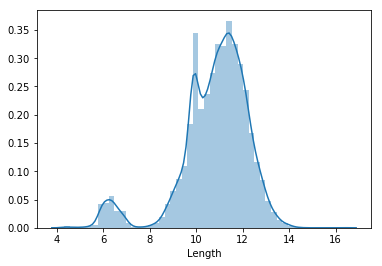

In [9]:
rpkm = pd.read_csv(outdir + '/rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
sns.distplot(np.log2(rpkm.Length + 1))

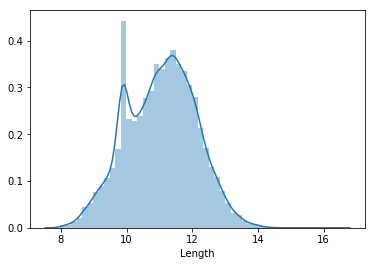

In [10]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

In [11]:
# convert to tpm
tpm_mat = process_rpkm(rpkm, conv_tpm=True)

In [12]:
tpm_mat.columns = list(samplesDF.group_unique)

In [13]:
tpm_mat.columns.rename('', inplace=True)

In [14]:
# tpm_paired_scatter(tpm_mat, strain='', tissue='')

In [15]:
sns.set_context('talk', font_scale=2)

In [16]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_mat)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group, samplesDF.cage])).reset_index()

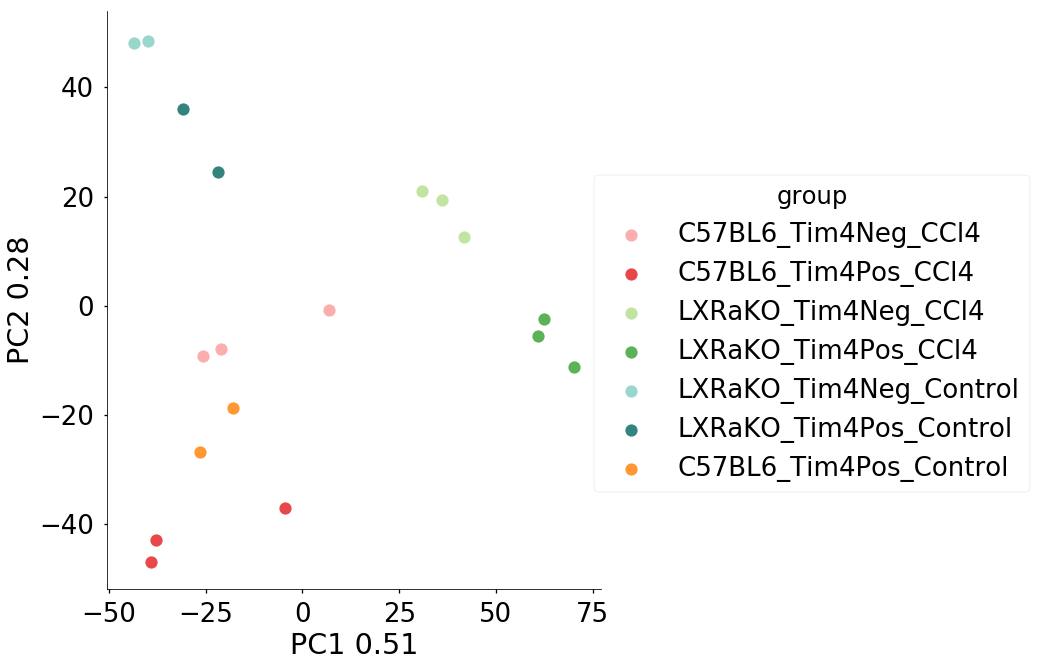

In [17]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', palette=color_dict,
                size=10, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))

* PC1 segregates on genotype.
* PC2 segregates TIM4+ (upper half) and TIM4- cells (lower half)
* interestingly control tim4+ mice appear to cluster with CCL4 diet Tim4negative cells - why?

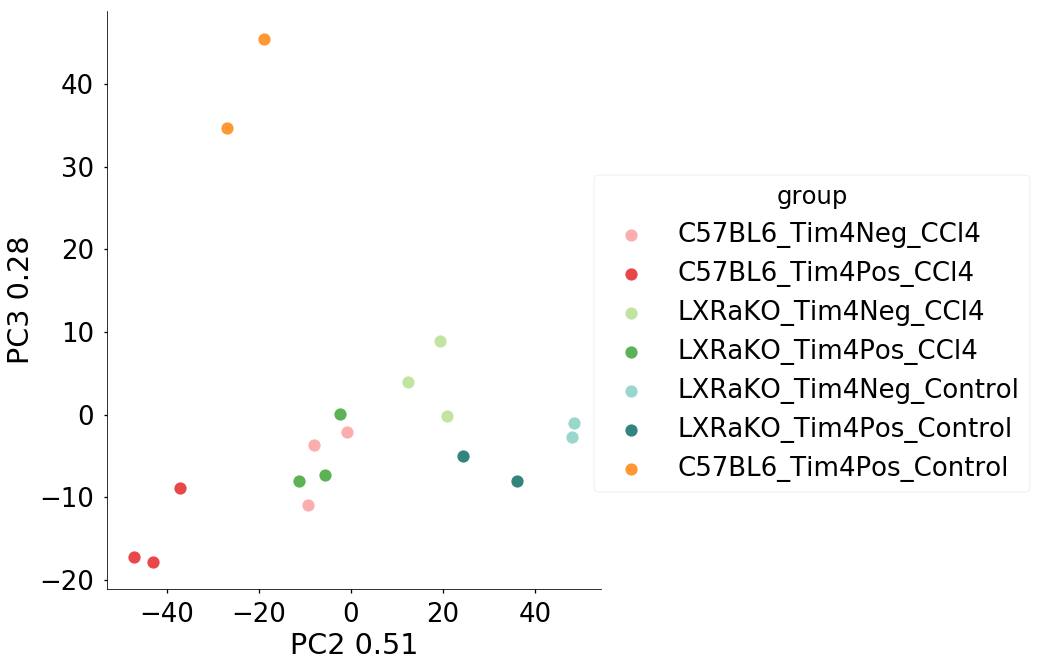

In [18]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group', palette=color_dict,
                size=10, scatter_kws={'s': 150})
ax.set(xlabel=('PC2 %.2f' % exp_var[0]), ylabel=('PC3 %.2f' % exp_var[1]))

### Lets try clustering on the top 1k or 10k most variable genes in the dataset

In [19]:
tpm_var = tpm_mat.var(axis=1).sort_values(ascending=False)

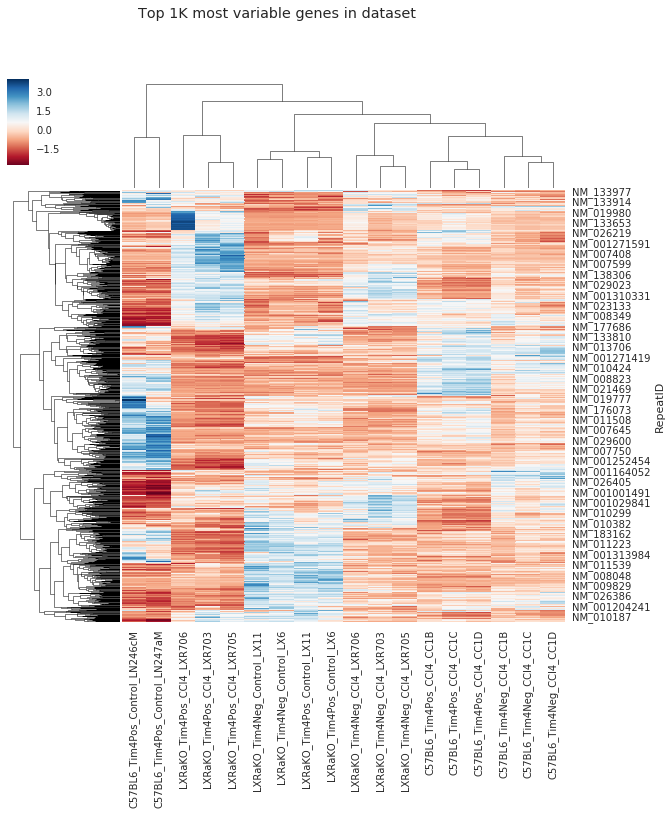

In [20]:
sns.set(font_scale=1)
g = sns.clustermap(tpm_mat.loc[list(tpm_var.iloc[:1000].index), :], z_score=0, cmap='RdBu')
g.fig.suptitle('Top 1K most variable genes in dataset') 

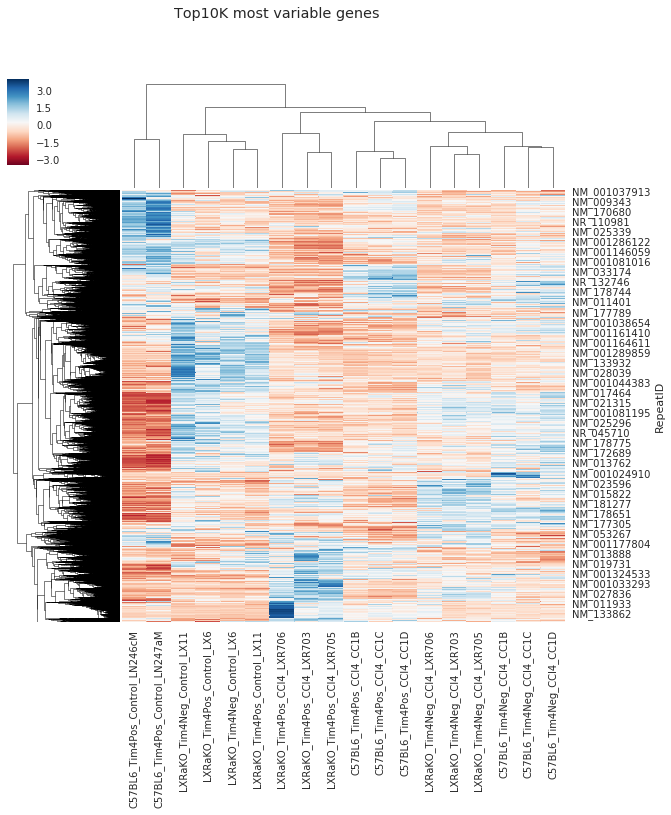

In [21]:
g = sns.clustermap(tpm_mat.loc[list(tpm_var.iloc[:10000].index), :], z_score=0, cmap='RdBu')
g.fig.suptitle('Top10K most variable genes') 

### Expression of LXRs in our different populations

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

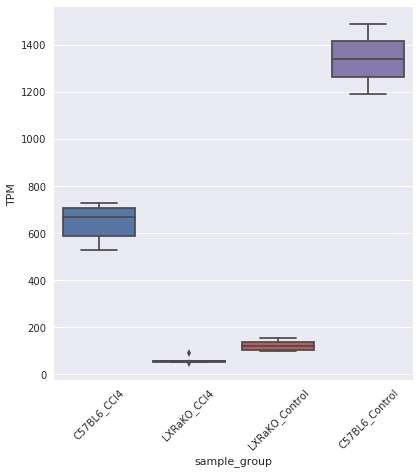

In [22]:
lxralpha = pd.DataFrame({'TPM': list(tpm_mat.loc['NM_001177730', :].values),
                        'sample_group': samplesDF.group_diet.tolist()})
g = sns.factorplot('sample_group', y='TPM', data=lxralpha, kind='box', size=6)
plt.xticks(rotation=45)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

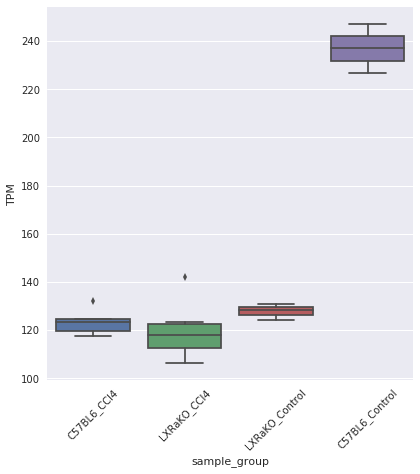

In [23]:
lxrbeta = pd.DataFrame({'TPM': list(tpm_mat.loc['NM_001285518', :].values),
                        'sample_group': samplesDF.group_diet.tolist()})
g = sns.factorplot('sample_group', y='TPM', data=lxrbeta, kind='box', size=6)
plt.xticks(rotation=45)


In [210]:
mm10_refseq.loc[mm10_refseq.gene.str.match('Mmp9'), :]

,gene
refseq_id,
NM_013599,Mmp9


In [207]:
# genes from Tacke et al 2014 annotated to functional categories
# Inflammatory: NM_008361 = IL1b, NM_001278601 = TNFalpha, NM_008337 = IFN-gamma, NM_021297 = TLR4, NM_008689 = NFkB
# NM_001177370 = NFkB2, NM_009987 = Cx3cr1
# CXCL16 (NK recruitment) = NM_023158, CCL2 = NM_011333, CCL5 = NM_013653
# Fibrosis: NM_011577 = TGF beta 1, NM_011057 = PDGFb, NM_008808 = PDGFa
# Fibrosis resolution: NM_013599 = MMP12, NM_008607 = MMP13, NM_013599 = MMP9, NM_010548 = IL10

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

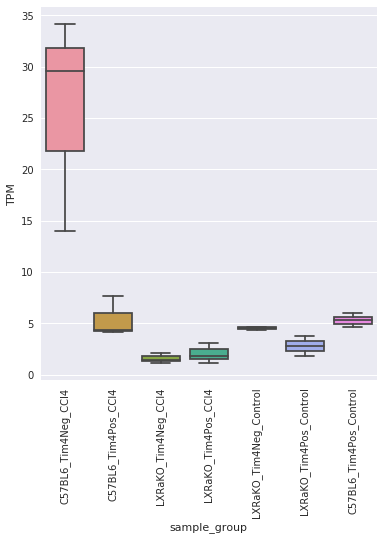

In [211]:
gene = pd.DataFrame({'TPM': list(tpm_mat.loc['NM_013599', :].values),
                        'sample_group': samplesDF.group_diet.tolist()})
g = sns.factorplot('sample_group', y='TPM', data=gene, kind='box', size=6)
plt.xticks(rotation=90)

In [260]:
gene_cat = {'NM_008361':'inflammatory', 'NM_001278601':'inflammatory',
            'NM_021297':'inflammatory',  # 'NM_008337':'inflammatory',
            'NM_008689':'inflammatory', 'NM_001177370':'inflammatory',
            'NM_009987':'inflammatory', 'NM_023158':'inflammatory',
            'NM_011333':'inflammatory', 'NM_013653':'inflammatory',
            'NM_011577':'pro-fibrosis', 'NM_011057':'pro-fibrosis',
            'NM_008808':'pro-fibrosis', 'NM_013599':'fibrosis-resolution',
            'NM_008607':'fibrosis-resolution', 'NM_013599':'fibrosis-resolution',
            'NM_010548':'fibrosis-resolution'}

pathway_colors = {'inflammatory':'#de2d26',
                  'pro-fibrosis':'#756bb1',
                  'fibrosis-resolution':'#31a354'}

liver_mac_dz = mm10_refseq.loc[gene_cat.keys()]
liver_mac_dz.loc[:, 'function'] = pd.Series(gene_cat)

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [266]:
log2_tpm_liverdz.columns = liver_mac_dz.gene.tolist()

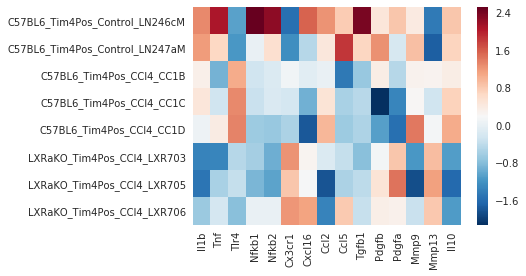

In [268]:
tim4posccl4_nolxrctrl = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
log2_tpm_liverdz = np.log2(tpm_mat.reindex(list(liver_mac_dz.index)) + 1).loc[:, list(tim4posccl4_nolxrctrl)].T
log2_tpm_liverdz.columns = liver_mac_dz.gene.tolist()
zscore_log2_tpm_liverdz = pd.DataFrame(stats.zscore(log2_tpm_liverdz, 0),
                                       index=log2_tpm_liverdz.index.tolist(),
                                       columns=log2_tpm_liverdz.columns.tolist())
new_col_order = [6, 7, 0, 1, 2, 3, 4, 5]
g = sns.heatmap(zscore_log2_tpm_liverdz.iloc[new_col_order, :], cmap='RdBu_r')

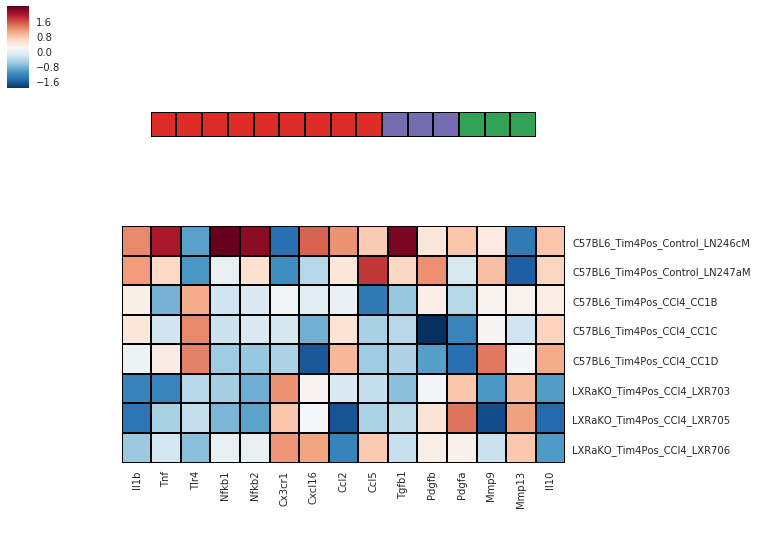

In [275]:
sns.clustermap(log2_tpm_liverdz.iloc[new_col_order, :], cmap='RdBu_r',
               row_cluster=False, col_cluster=False, z_score=1,
               col_colors=list(liver_mac_dz.function.map(pathway_colors)),
               square=True, linewidths=1, linecolor='black', figsize=(10,10))

## Differential Analysis (DESeq2)

Prep data for importing into R

In [26]:
# import the raw count file
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

# remove samples with length < 250bp
counts_df = counts_df.loc[counts_df.Length >= 250, :]

# create gene name column
counts_df['Gene'] = counts_df.loc[:, 'Annotation/Divergence'].str.split('|').str[0]

# clean up columns
counts_df.columns = pd.Series(counts_df.columns)\
        .str.split(r" \(").str[0]\
        .str.split('/.*/').str[-1]
counts_df = counts_df.set_index('Transcript/RepeatID')
counts_mat = counts_df.iloc[:, 7:]

#### Write the data for DESeq2

In [27]:
# raw count matrix for DESeq
deseq_file = raw_counts_file.replace('.txt', '_deseq.txt')                                   
# if not os.path.isfile(outdir + kupffer_raw_counts_file):
counts_mat.to_csv(outdir + deseq_file, sep='\t')

# Column Data Information for DESeq, make sure to drop the samples we are excluding
# we will combine C57 and NCorWT for this analysis
samplesDF.genotype = samplesDF.genotype.replace({'NCoRWT':'C57BL6'})
samplesDF['group'] = samplesDF['genotype'] + '_' + samplesDF['cells']
samplesDF['group_diet'] = samplesDF['genotype'] + '_' + samplesDF['cells'] + '_' + samplesDF['diet']
samplesDF['group_unique'] = samplesDF['group'] + '_' + samplesDF['cage']
samplesDF.to_csv(outdir + 'deseq_coldata.txt', sep='\t')

### Read in DESeq results

In [28]:
c57bl6_control = pd.read_csv(outdir + 'C57_Tim4Pos_CCl4_vs_control_Deseq_results.txt', sep='\t')

In [29]:
# annotate c57bl6 with gene
c57bl6_control['gene'] = counts_df['Gene']
c57bl6_control.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
NM_011029,545.928204,5.005570,0.265972,18.819914,5.186871e-79,7.810909e-75,Rpsa
NM_009930,1018.556539,5.170937,0.292462,17.680723,5.903458e-70,4.445008e-66,Col3a1
NM_024266,804.522551,4.516831,0.268513,16.821665,1.693329e-63,8.499947e-60,Rps25
NM_009970,5020.550877,-1.593958,0.096898,-16.449833,8.409998e-61,3.166154e-57,Csf2ra
NM_001281818,886.667018,5.587862,0.341496,16.362913,3.518859e-60,1.059810e-56,Specc1


In [30]:
# genes with only fc cutoffs
c57bl6_ccl4_fc2 = (np.abs(c57bl6_control.log2FoldChange) >= 1)
c57bl6_ccl4_fc2_genes = list(c57bl6_control.loc[c57bl6_ccl4_fc2, :].index)
c57bl6_ccl4_fc2_up = (c57bl6_control.log2FoldChange >= 1)
c57bl6_ccl4_fc2_up_genes = list(c57bl6_control.loc[c57bl6_ccl4_fc2_up, :].index)
c57bl6_ccl4_fc2_dn = (c57bl6_control.log2FoldChange <= -1)
c57bl6_ccl4_fc2_dn_genes = list(c57bl6_control.loc[c57bl6_ccl4_fc2_dn, :].index)

In [31]:
# what genes w/ padj < 0.01 and fc up and fc dn
c57bl6_ccl4_p01_fc2 = (c57bl6_control.padj <= 0.01) & (np.abs(c57bl6_control.log2FoldChange) >= 1)
c57bl6_ccl4_p01_fc2_genes = list(c57bl6_control.loc[c57bl6_ccl4_p01_fc2, :].index)
c57bl6_ccl4_p01_fc2_up = (c57bl6_control.padj <= 0.01) & (c57bl6_control.log2FoldChange >= 1)
c57bl6_ccl4_p01_fc2_up_genes = list(c57bl6_control.loc[c57bl6_ccl4_p01_fc2_up, :].index)
c57bl6_ccl4_p01_fc2_dn = (c57bl6_control.padj <= 0.01) & (c57bl6_control.log2FoldChange <= -1)
c57bl6_ccl4_p01_fc2_dn_genes = list(c57bl6_control.loc[c57bl6_ccl4_p01_fc2_dn, :].index)

In [32]:
# write out gene lists for metascape
f = open(outdir + '/c57bl6_ccl4_vs_control_deseq_p01_fc2.txt', 'w')
gene_list = '\n'.join(c57bl6_control.loc[c57bl6_ccl4_p01_fc2, 'gene'].tolist())
f.write(gene_list)
f.close()

f = open(outdir + '/c57bl6_ccl4_vs_control_deseq_p01_fc2_up.txt', 'w')
gene_list = '\n'.join(c57bl6_control.loc[c57bl6_ccl4_p01_fc2_up, 'gene'].tolist())
f.write(gene_list)
f.close()

f = open(outdir + '/c57bl6_ccl4_vs_control_deseq_p01_fc2_dn.txt', 'w')
gene_list = '\n'.join(c57bl6_control.loc[c57bl6_ccl4_p01_fc2_dn, 'gene'].tolist())
f.write(gene_list)
f.close()

## Overall plots of genes significantly changed (p < 0.01 and FC > 2) by CCl4 diet in controls

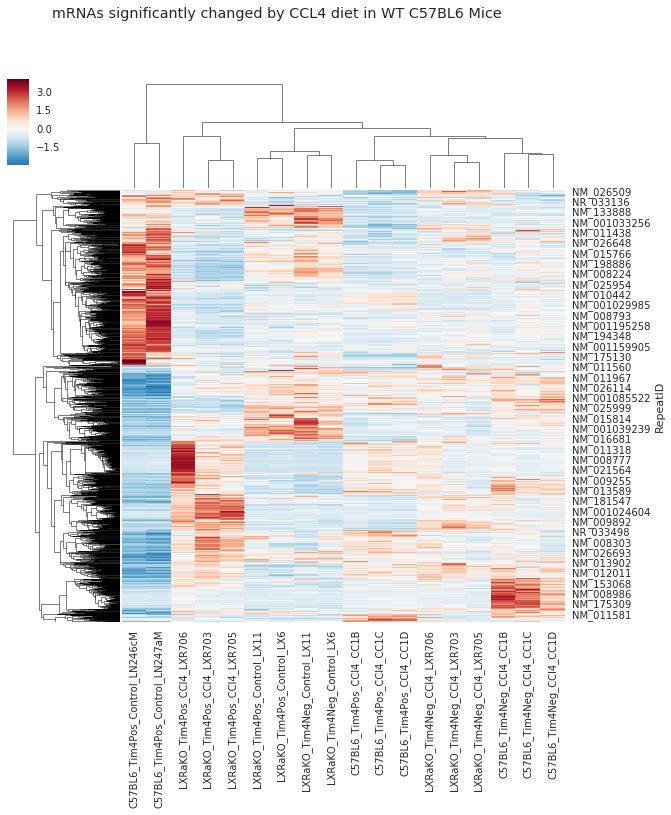

In [33]:
g = sns.clustermap(tpm_mat.reindex(c57bl6_ccl4_p01_fc2_genes).dropna(), z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('mRNAs significantly changed by CCL4 diet in WT C57BL6 Mice')

### Plot subsetted to only compare to tim4 positive cells

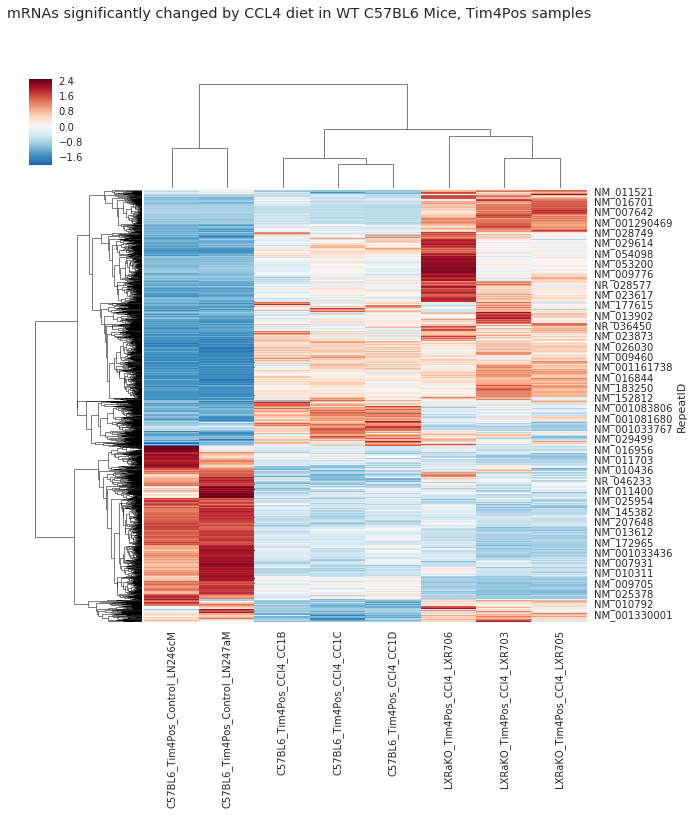

In [34]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(c57bl6_ccl4_p01_fc2_genes).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('mRNAs significantly changed by CCL4 diet in WT C57BL6 Mice, Tim4Pos samples') 

# Violin Plot of Overal Gene Patterns for Upregulated Genes

In [143]:
# subset tim4 positive cells
tim4pos = samplesDF.cells == 'Tim4Pos'
# select kupffer cell specific genes in tim4pos cells
c57bl6_ccl4_p01_fc2_genes_tim4pos = tpm_mat.reindex(list(c57bl6_ccl4_p01_fc2_genes)).loc[:, list(tim4pos)].dropna().drop_duplicates()
c57bl6_ccl4_p01_fc2_genes_tim4pos.columns = list(samplesDF.loc[tim4pos, 'group_diet'])
# melt data frame for plotting as violin
c57bl6_ccl4_p01_fc2_genes_tim4pos_melt = c57bl6_ccl4_p01_fc2_genes_tim4pos.T.reset_index().melt(id_vars='index', var_name = 'RepeatID')
# create log2 column for plotting
c57bl6_ccl4_p01_fc2_genes_tim4pos_melt['log2tpm'] = np.log2(c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.value + 1)
# re-sort so that the index order is more useful
c57bl6_ccl4_p01_fc2_genes_tim4pos_melt = c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.sort_values(by='index').reset_index(drop=True)

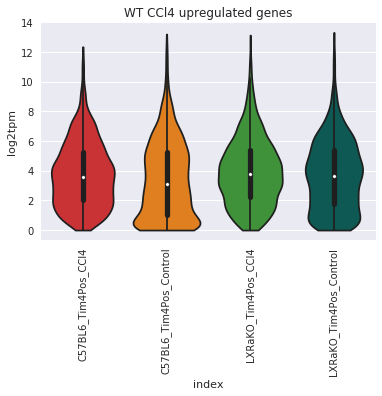

In [145]:
g = sns.violinplot(x='index', y='log2tpm', data=c57bl6_ccl4_p01_fc2_genes_tim4pos_melt, palette=color_dict, cut=0)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('WT CCl4 upregulated genes')

In [146]:
print(stats.ranksums(c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_CCl4', 'value'],
                     c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='C57BL6_Tim4Pos_CCl4', 'value']))
print(stats.ranksums(c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_Control', 'value'],
                     c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='C57BL6_Tim4Pos_Control', 'value']))
print(stats.ranksums(c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_CCl4', 'value'],
                     c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_Control', 'value']))
print(stats.ranksums(c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='C57BL6_Tim4Pos_CCl4', 'value'],
                     c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[c57bl6_ccl4_p01_fc2_genes_tim4pos_melt.loc[:, 'index']=='C57BL6_Tim4Pos_Control', 'value']))

RanksumsResult(statistic=3.610163315026186, pvalue=0.00030600427323588473)
RanksumsResult(statistic=6.0495007170166364, pvalue=1.4529541827634502e-09)
RanksumsResult(statistic=4.4603995443629749, pvalue=8.180699755519689e-06)
RanksumsResult(statistic=8.6769606019406105, pvalue=4.0648584360728139e-18)


### Plot subsetted to only compare to tim4 negative cells

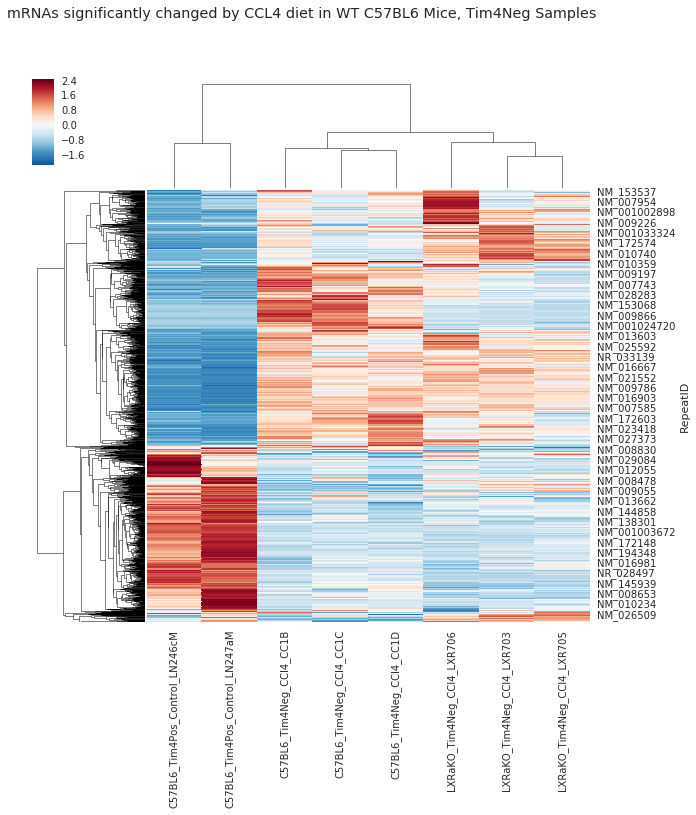

In [35]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Neg')))
g = sns.clustermap(tpm_mat.reindex(c57bl6_ccl4_p01_fc2_genes).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('mRNAs significantly changed by CCL4 diet in WT C57BL6 Mice, Tim4Neg Samples') 

LXR knockout cells cluster distinctly from WT cells, however diet is the greatest effect for Tim4Pos and Tim4Neg cells. Perhaps to be expected most of the differences between the two groups

Lets write these genes out to get a baseline for metascape analysis - what pathways are turned on/off by CCl4 diet?

### If interested can also do this with only upregulated or downregulated genes...

Next we want to try and subset the genes that are upregulated by the CCl4 diet in control mice but not in LXRalpha knockout mice. Should these genes be defined by:
* direct comparison of Control on CCl4 to LXR alpha KO on CCl4? ie looking for genes that are significantly different between the two populations?
* comparing the C57BL6 Tim4Pos Control diet to the LXRalpha KO CCL4 diet and looking for genes that are NOT significantly different by DESeq and then intersecting that list with differential genes when comparing diet effect in WT mice?

## Subset genes that are 'lost' in LXRaKO CCL4
**We will try first by directly comparing of LXRaKO Tim4Pos CCL4 to WT Tim4Pos CCL4 with DESeq2**

In [36]:
lxrako_wt_ccl4 = pd.read_csv(outdir + 'LXRaKO_Tim4Pos_CCl4_vs_C57BL6_Tim4Pos_CCl4_Deseq_results.txt', sep='\t')
lxrako_wt_ccl4['gene'] = counts_df['Gene']

In [37]:
# genes with only fc cutoffs
lxrako_wt_ccl4_fc2 = (np.abs(lxrako_wt_ccl4.log2FoldChange) >= 1)
lxrako_wt_ccl4_fc2_genes = list(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_fc2, :].index)
lxrako_wt_ccl4_fc2_up = (lxrako_wt_ccl4.log2FoldChange >= 1)
lxrako_wt_ccl4_fc2_up_genes = list(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_fc2_up, :].index)
lxrako_wt_ccl4_fc2_dn = (lxrako_wt_ccl4.log2FoldChange <= -1)
lxrako_wt_ccl4_fc2_dn_genes = list(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_fc2_dn, :].index)

In [38]:
# what genes w/ padj < 0.01 and fc up and fc dn
lxrako_wt_ccl4_p01_fc2 = (lxrako_wt_ccl4.padj <= 0.01) & (np.abs(lxrako_wt_ccl4.log2FoldChange) >= 1)
lxrako_wt_ccl4_p01_fc2_genes = list(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_p01_fc2, :].index)
lxrako_wt_ccl4_p01_fc2_up = (lxrako_wt_ccl4.padj <= 0.01) & (lxrako_wt_ccl4.log2FoldChange >= 1)
lxrako_wt_ccl4_p01_fc2_up_genes = list(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_p01_fc2_up, :].index)
lxrako_wt_ccl4_p01_fc2_dn = (lxrako_wt_ccl4.padj <= 0.01) & (lxrako_wt_ccl4.log2FoldChange <= -1)
lxrako_wt_ccl4_p01_fc2_dn_genes = list(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_p01_fc2_dn, :].index)

In [150]:
(lxrako_wt_ccl4.loc[lxrako_wt_ccl4_p01_fc2_up, :].gene == 'Pparg').value_counts()

False    835
True       1
Name: gene, dtype: int64

#### Define set of genes that are upregulated on CCL4 Diet in WT mice and downregulated in LXRaKO CCL4 compared to WT CCL4

In [39]:
# this is a less strict set with only FC bounding
lxra_dep_diet_up_fc2 = list(set(c57bl6_ccl4_fc2_up_genes).intersection(lxrako_wt_ccl4_fc2_dn_genes))
lxra_dep_diet_dn_fc2 = list(set(c57bl6_ccl4_fc2_dn_genes).intersection(lxrako_wt_ccl4_fc2_up_genes))
# this is a strict set with low p value
lxra_dep_diet_up_p01_fc2 = list(set(c57bl6_ccl4_p01_fc2_up_genes).intersection(lxrako_wt_ccl4_p01_fc2_dn_genes))
lxra_dep_diet_dn_p01_fc2 = list(set(c57bl6_ccl4_p01_fc2_dn_genes).intersection(lxrako_wt_ccl4_p01_fc2_up_genes))

### Tim4Pos Cells, fc only criteria, upreg

**Lets look at these genes in tim4pos cells**

(354, 8)


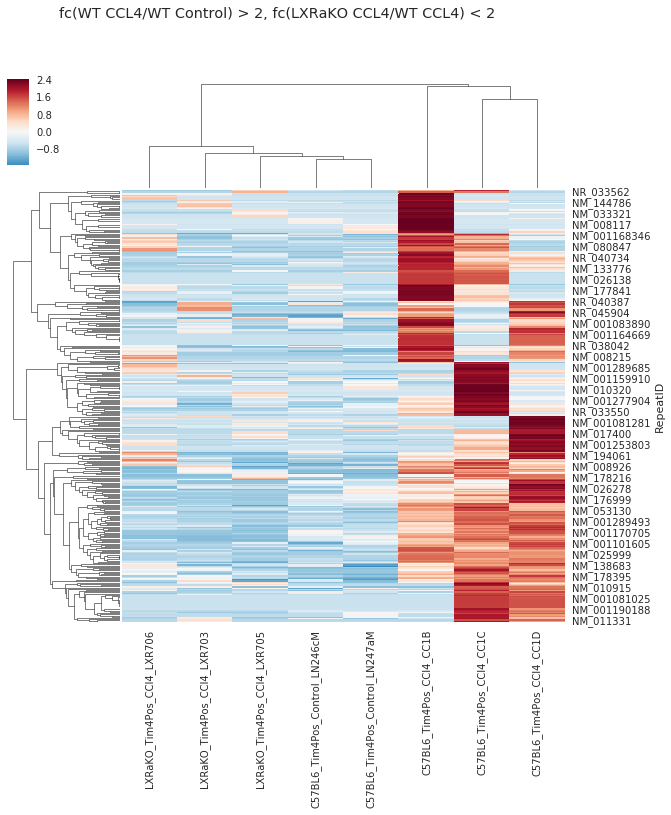

In [40]:
# this group is enriched for some very lowly expressed genes, so we need to filter them out first
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
tpm_prefilt = tpm_mat.reindex(lxra_dep_diet_up_fc2).dropna().loc[:, list(subgroup)]
tpm_filt = tpm_prefilt.loc[(tpm_prefilt != 0).sum(1) > 1, :]
print(tpm_filt.shape)
g = sns.clustermap(tpm_filt, z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) > 2, fc(LXRaKO CCL4/WT CCL4) < 2') 

The above clustering is somewhat problematic because it appears to also be driven by genes that are highly variable in the tim4positive cluster on the diet - ie only upregulated in one sample and not the others. Are these high confidence calls or are they distractors that are due to within sample variance?

In [41]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_up_fc2.txt', 'w')
gene_list = '\n'.join(tpm_filt.index.tolist())
f.write(gene_list)
f.close()

### Tim4Pos Cells, fc down criteria

(417, 8)


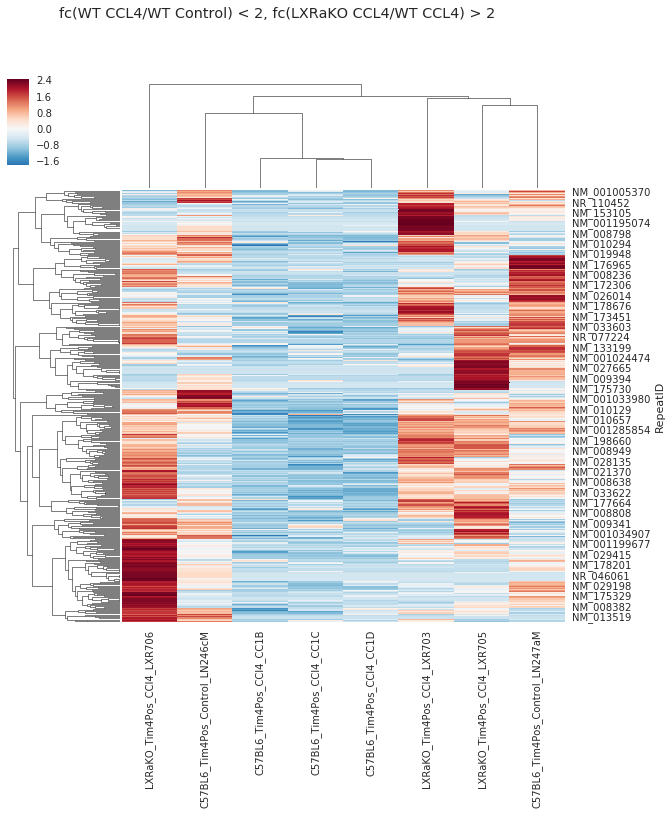

In [42]:
# this group is enriched for some very lowly expressed genes, so we need to filter them out first
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
tpm_prefilt = tpm_mat.reindex(lxra_dep_diet_dn_fc2).dropna().loc[:, list(subgroup)]
tpm_filt = tpm_prefilt.loc[(tpm_prefilt != 0).sum(1) > 1, :]
print(tpm_filt.shape)
g = sns.clustermap(tpm_filt, z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) < 2, fc(LXRaKO CCL4/WT CCL4) > 2') 

### Tim4Pos Cells, fc up and p value criteria

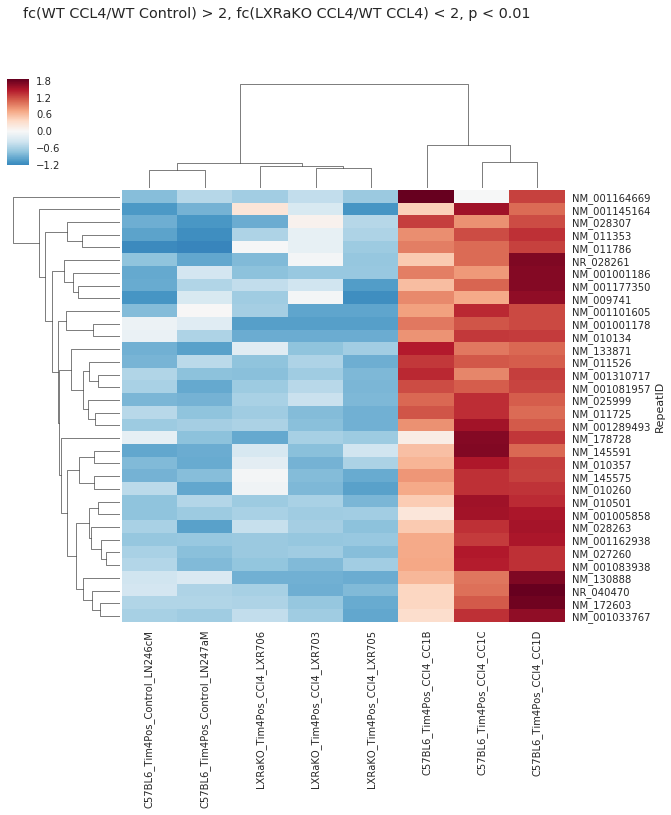

In [43]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(lxra_dep_diet_up_p01_fc2).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) > 2, fc(LXRaKO CCL4/WT CCL4) < 2, p < 0.01') 

In [44]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_up_p01_fc2.txt', 'w')
gene_list = '\n'.join(lxra_dep_diet_up_p01_fc2)
f.write(gene_list)
f.close()

### Tim4Pos Cells, fc dn and p value criteria

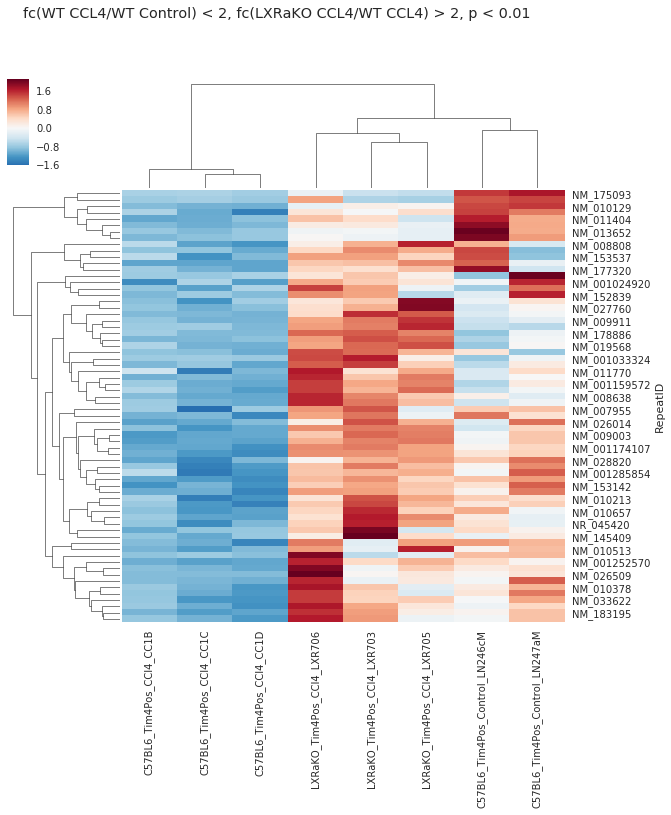

In [45]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(lxra_dep_diet_dn_p01_fc2).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) < 2, fc(LXRaKO CCL4/WT CCL4) > 2, p < 0.01') 

In [46]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_dn_p01_fc2.txt', 'w')
gene_list = '\n'.join(lxra_dep_diet_dn_p01_fc2)
f.write(gene_list)
f.close()

### Volcano plot comparing Tim4Pos cells on diet from WT and LXR mice

In [47]:
lxrako_wt_ccl4.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
NM_009690,55402.943837,-8.777082,0.168740,-52.015382,0.000000e+00,0.000000e+00,Cd5l
NM_028709,1105.020390,-5.605412,0.180755,-31.011021,3.828841e-211,2.951079e-207,Btbd11
NM_029620,765.207493,-7.275635,0.294761,-24.683147,1.622517e-134,8.337033e-131,Pcolce2
NM_001252207,753.499929,-7.207729,0.297579,-24.221205,1.330247e-129,5.126438e-126,Kcnj16
NM_013484,1094.325784,-4.305591,0.179664,-23.964706,6.492427e-127,2.001615e-123,C2


In [48]:
lxrako_wt_ccl4['-log10p'] = -np.log10(lxrako_wt_ccl4.padj)
lxrako_wt_ccl4.loc[lxrako_wt_ccl4['-log10p'] == np.inf, '-log10p'] = -np.log10(1e-200)
lxrako_wt_ccl4['sig'] = lxrako_wt_ccl4.padj <= 0.01

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


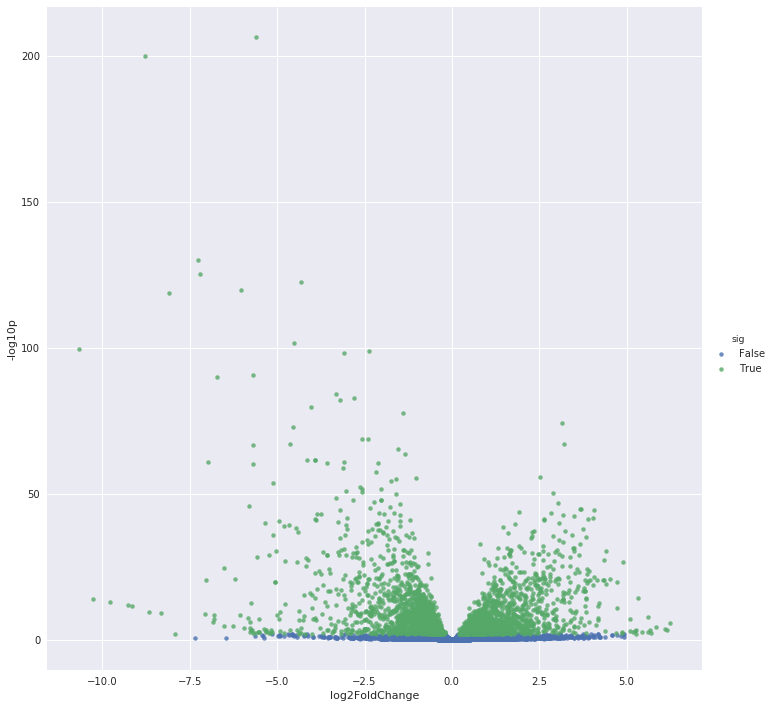

In [49]:
sns.lmplot('log2FoldChange', '-log10p', data=lxrako_wt_ccl4, fit_reg=False,
           size=10, hue='sig', scatter_kws={'s': 20})

Try using unadjusted tpm values

In [50]:
samplesDF.head()

,subject,sample_type,path,batch,genotype,cells,diet,cage,group,group_diet,group_unique,color
0,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4si...,kupffer,/data/mm10/Kupffer/RNA/mouse_C57Bl6_M_KupfferT...,0,C57BL6,Tim4Neg,CCl4,CC1B,C57BL6_Tim4Neg,C57BL6_Tim4Neg_CCl4,C57BL6_Tim4Neg_CC1B,#fb9a99
1,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4si...,kupffer,/data/mm10/Kupffer/RNA/mouse_C57Bl6_M_KupfferT...,0,C57BL6,Tim4Neg,CCl4,CC1C,C57BL6_Tim4Neg,C57BL6_Tim4Neg_CCl4,C57BL6_Tim4Neg_CC1C,#fb9a99
2,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4si...,kupffer,/data/mm10/Kupffer/RNA/mouse_C57Bl6_M_KupfferT...,0,C57BL6,Tim4Neg,CCl4,CC1D,C57BL6_Tim4Neg,C57BL6_Tim4Neg_CCl4,C57BL6_Tim4Neg_CC1D,#fb9a99
3,mouse_C57Bl6_M_KupfferTim4Pos_RNA_polyA_CCl4si...,kupffer,/data/mm10/Kupffer/RNA/mouse_C57Bl6_M_KupfferT...,0,C57BL6,Tim4Pos,CCl4,CC1B,C57BL6_Tim4Pos,C57BL6_Tim4Pos_CCl4,C57BL6_Tim4Pos_CC1B,#e31a1c
4,mouse_C57Bl6_M_KupfferTim4Pos_RNA_polyA_CCl4si...,kupffer,/data/mm10/Kupffer/RNA/mouse_C57Bl6_M_KupfferT...,0,C57BL6,Tim4Pos,CCl4,CC1C,C57BL6_Tim4Pos,C57BL6_Tim4Pos_CCl4,C57BL6_Tim4Pos_CC1C,#e31a1c


In [51]:
c57bl6_tim4pos_ccl4 = tpm_mat.loc[:, list(samplesDF.group_diet=='C57BL6_Tim4Pos_CCl4')].mean(1)
lxrako_tim4pos_ccl4 = tpm_mat.loc[:, list(samplesDF.group_diet=='LXRaKO_Tim4Pos_CCl4')].mean(1)
fc = lxrako_tim4pos_ccl4 / c57bl6_tim4pos_ccl4
fc = fc.replace([-np.inf, np.inf, 0], np.nan).dropna()
fc.describe()
log2fc_lxrako_c57bl6_ccl4_tim4pos = np.log2(fc)

In [52]:
volc_df = pd.DataFrame({'log2fc': log2fc_lxrako_c57bl6_ccl4_tim4pos,
              '-log10p': lxrako_wt_ccl4['-log10p']}).dropna()
lxrako_wt_ccl4['sig'] = lxrako_wt_ccl4['-log10p'] >= -np.log10(0.01)

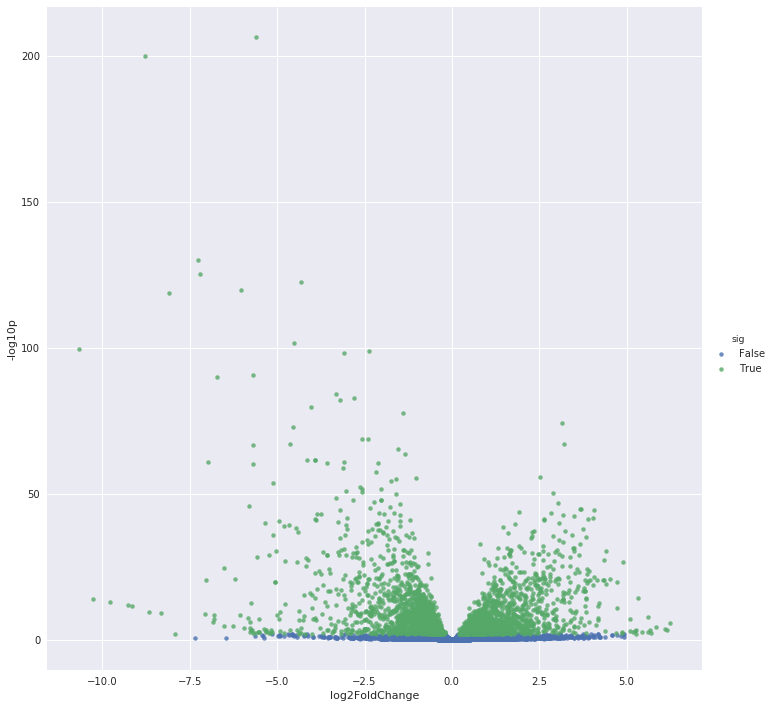

In [53]:
sns.lmplot('log2FoldChange', '-log10p', data=lxrako_wt_ccl4, fit_reg=False,
           size=10, hue='sig', scatter_kws={'s': 20})

## Instead we will define our gene set as those differentially upregulated on CCL4 in WT but not different when comparing LXRaKO CCL4 to WT Control diet

In [54]:
lxrako_ccl4_vs_wt_control = pd.read_csv(outdir + 'LXRaKO_Tim4Pos_CCl4_vs_C57BL6_Tim4Pos_Control_Deseq_results.txt', sep='\t')
lxrako_ccl4_vs_wt_control['gene'] = counts_df['Gene']

In [55]:
lxrako_ccl4_vs_wt_control_nonsig = lxrako_ccl4_vs_wt_control.padj >= 0.01
lxrako_ccl4_vs_wt_control_nonsig_genes = list(lxrako_ccl4_vs_wt_control.loc[lxrako_ccl4_vs_wt_control_nonsig, :].index)

In [56]:
# define lax intersections.
lxra_dep_diet_up_fc2_lax = list(set(c57bl6_ccl4_fc2_up_genes).intersection(lxrako_ccl4_vs_wt_control_nonsig_genes))
lxra_dep_diet_up_p01_fc2_lax = list(set(c57bl6_ccl4_p01_fc2_up_genes).intersection(lxrako_ccl4_vs_wt_control_nonsig_genes))
# define lax intersections.
lxra_dep_diet_dn_fc2_lax = list(set(c57bl6_ccl4_fc2_dn_genes).intersection(lxrako_ccl4_vs_wt_control_nonsig_genes))
lxra_dep_diet_dn_p01_fc2_lax = list(set(c57bl6_ccl4_p01_fc2_dn_genes).intersection(lxrako_ccl4_vs_wt_control_nonsig_genes))

### Tim4Pos Cells, using only FC criteria in comparing WT CCL4 to Control

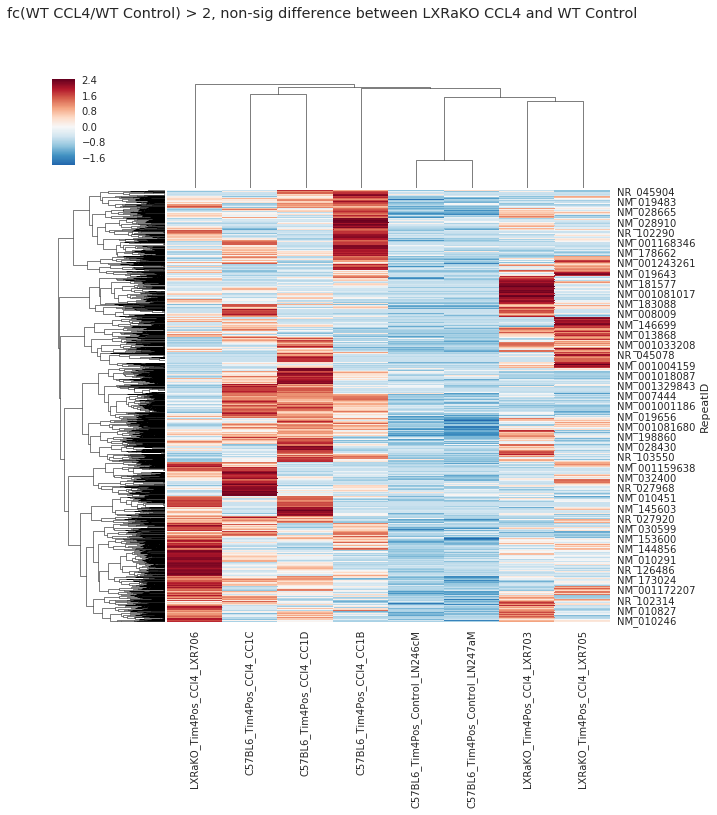

In [57]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
tpm_prefilt = tpm_mat.reindex(lxra_dep_diet_up_fc2_lax).dropna().loc[:, list(subgroup)]
tpm_filt = tpm_prefilt.loc[(tpm_prefilt != 0).sum(1) > 1, :]
g = sns.clustermap(tpm_filt,
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) > 2, non-sig difference between LXRaKO CCL4 and WT Control') 

In [58]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_up_fc2_lax.txt', 'w')
gene_list = '\n'.join(lxra_dep_diet_up_fc2_lax)
f.write(gene_list)
f.close()

### Tim4Pos Cells, using only FC dn criteria in comparing WT CCL4 to Control

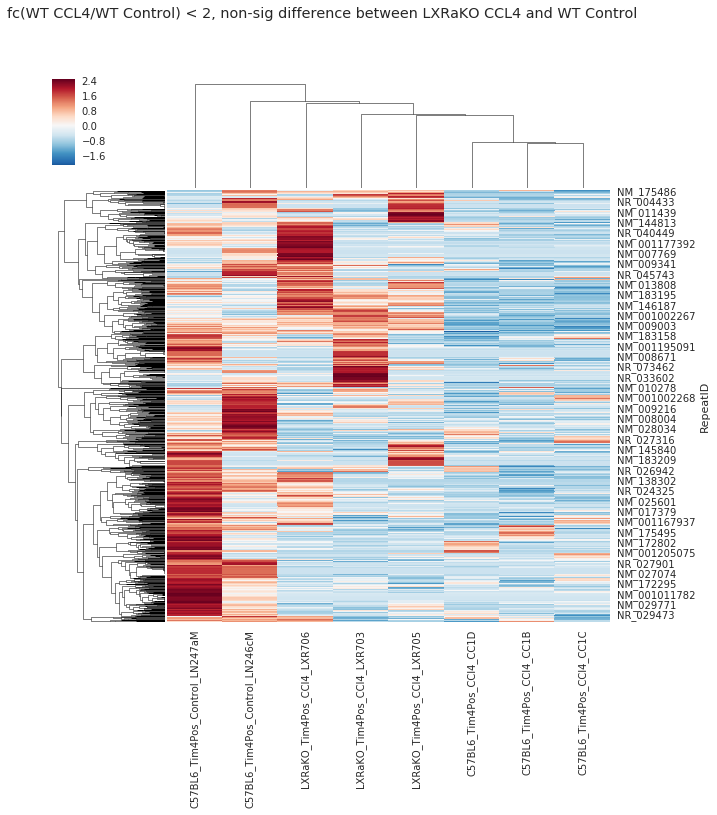

In [59]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
tpm_prefilt = tpm_mat.reindex(lxra_dep_diet_dn_fc2_lax).dropna().loc[:, list(subgroup)]
tpm_filt = tpm_prefilt.loc[(tpm_prefilt != 0).sum(1) > 1, :]
g = sns.clustermap(tpm_filt,
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) < 2, non-sig difference between LXRaKO CCL4 and WT Control') 

In [60]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_up_p01_fc2_lax.txt', 'w')
gene_list = '\n'.join(lxra_dep_diet_up_p01_fc2_lax)
f.write(gene_list)
f.close()

### Tim4Pos Cells, using FC and P value Criteria

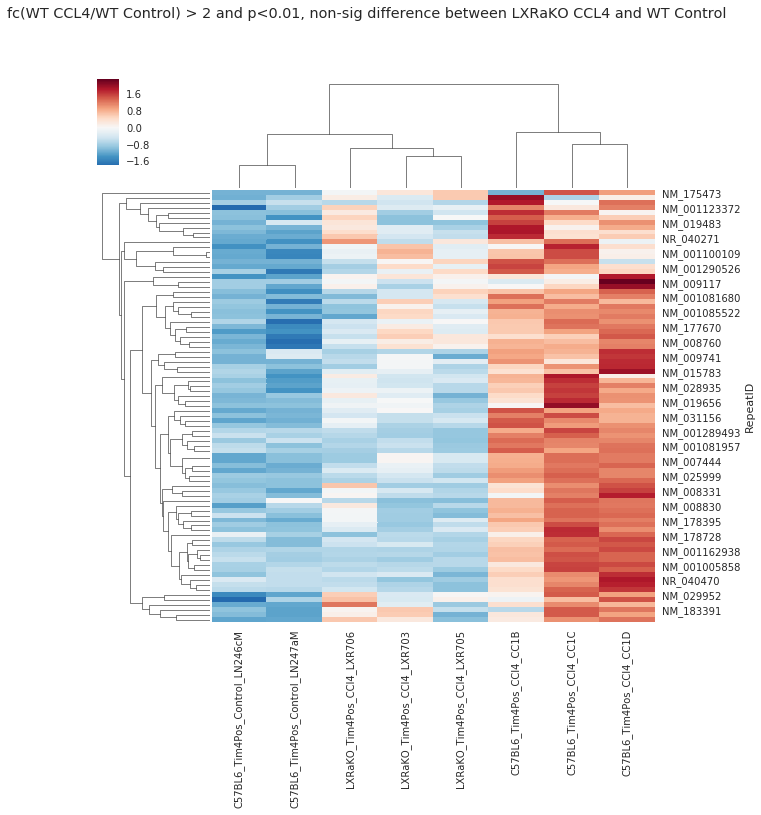

In [61]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(lxra_dep_diet_up_p01_fc2_lax).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) > 2 and p<0.01, non-sig difference between LXRaKO CCL4 and WT Control') 

In [62]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_up_p01_fc2_lax.txt', 'w')
gene_list = '\n'.join(lxra_dep_diet_up_p01_fc2_lax)
f.write(gene_list)
f.close()

### Tim4Pos Cells, using FC and P value Criteria

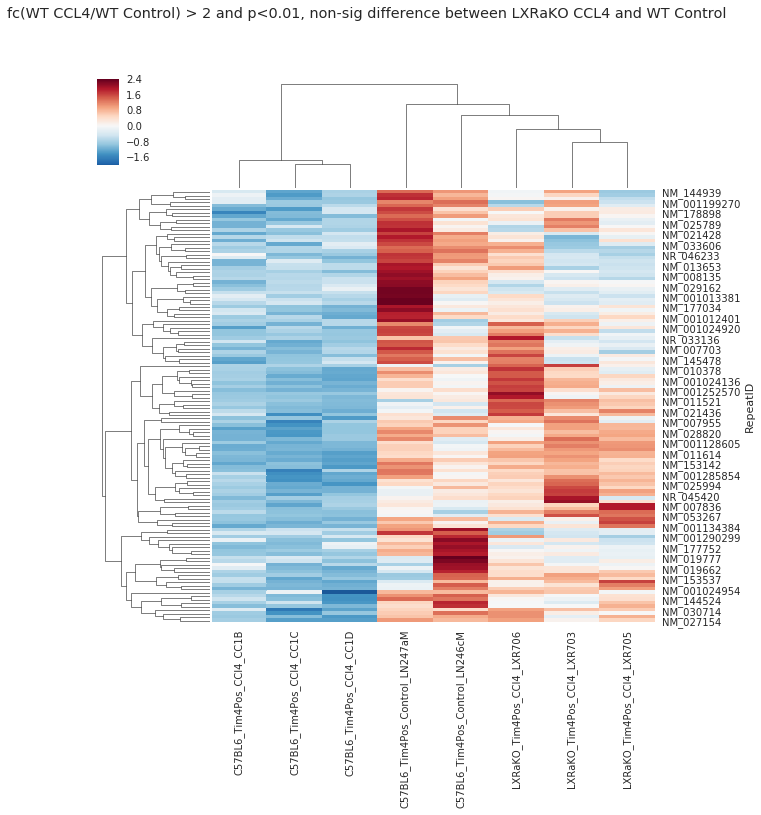

In [63]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(lxra_dep_diet_dn_p01_fc2_lax).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(WT CCL4/WT Control) > 2 and p<0.01, non-sig difference between LXRaKO CCL4 and WT Control') 

In [64]:
# write these genes to list for metascape
f = open(outdir + '/lxra_dep_diet_dn_p01_fc2_lax.txt', 'w')
gene_list = '\n'.join(lxra_dep_diet_dn_p01_fc2_lax)
f.write(gene_list)
f.close()

## Next, look at genes that were upregulated by the lxr knockout in the context of the ccl4 diet
_____
This should be enriched for inflammatory genes based on the "transrepression" model of LXR blocking inflammatory gene signalling

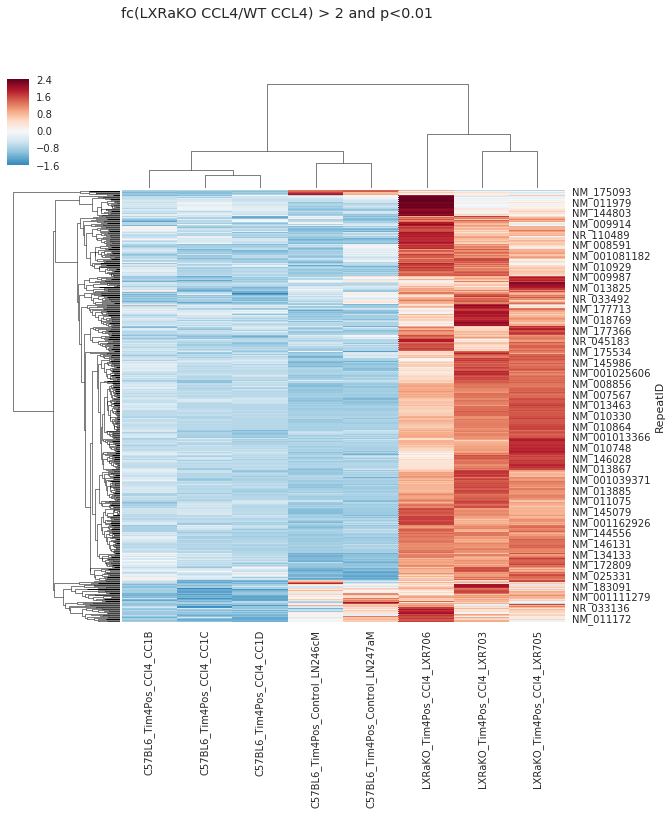

In [65]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(lxrako_wt_ccl4_p01_fc2_up_genes).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(LXRaKO CCL4/WT CCL4) > 2 and p<0.01') 

In [66]:
# write these genes to list for metascape
f = open(outdir + '/lxrako_wt_ccl4_p01_fc2_up.txt', 'w')
gene_list = '\n'.join(lxrako_wt_ccl4_p01_fc2_up_genes)
f.write(gene_list)
f.close()

# write these genes to list for metascape
f = open(outdir + '/lxrako_wt_ccl4_p01_fc2_dn.txt', 'w')
gene_list = '\n'.join(lxrako_wt_ccl4_p01_fc2_dn_genes)
f.write(gene_list)
f.close()

## All differential genes on LXR diet

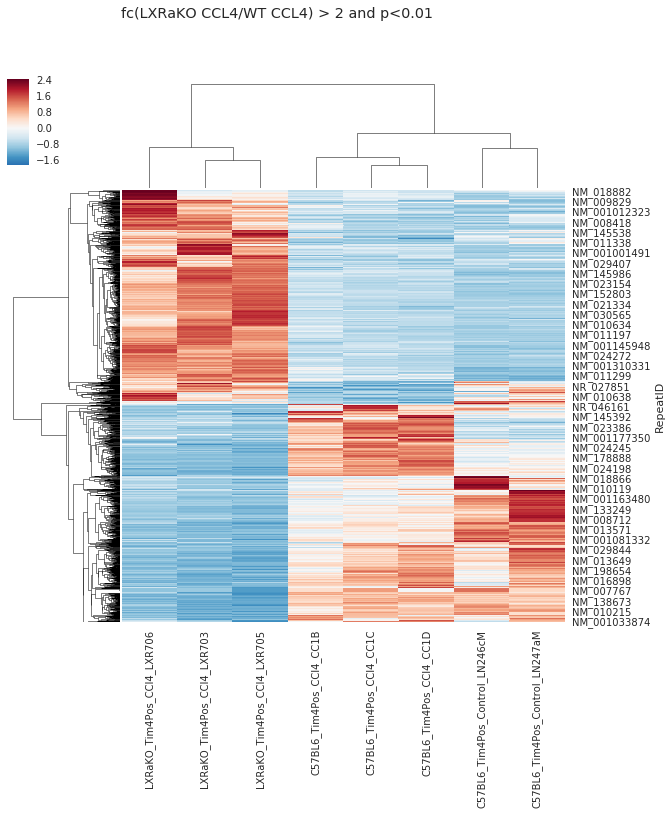

In [67]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_mat.reindex(lxrako_wt_ccl4_p01_fc2_genes).dropna().loc[:, list(subgroup)],
               z_score=0, cmap='RdBu_r', center=0)
g.fig.suptitle('fc(LXRaKO CCL4/WT CCL4) > 2 and p<0.01') 

# Repeat the analysis in Tim4 Negative Cells
_____
These cells still express LXR alpha but could show a different effect of the knockout.. however

# Pathway analysis

lets look at the pro-resolution lipid remodeling genes from Nathan's 2017 Cell Metabolism paper

In [68]:
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt', sep='\t', names=['refseq_id', 'gene'], index_col=0)

mm10_refseq_dict = {}
f = open('/home/h1bennet/LXR/data/mm10_refseq_genename.txt')
for line in f:
    (refseq, gene) = line.split()
    mm10_refseq_dict[refseq] = gene

In [69]:
lipid_met_genes = ['Acot4', 'Acaa1b', 'Acaa2', 'Hadha', 'Fads1', 'Acox1', 'Ppt1', 'Tecr',
                   'Ppt2', 'Elovl1', 'Fads2', 'Echs1', 'Scd2', 'Ptplb', 'Hadhb', 'Pecr',
                   'Acot1', 'Mecr', 'Scd1', 'Acot7', 'Acaa1a', 'Hsd17b12', 'Elovl2', 'Elovl7',
                   'Scd3', 'Scd4']
# select genes so we can get refseq ids
lipid_met_genes_refseq = mm10_refseq.loc[mm10_refseq.gene.str.contains('|'.join(lipid_met_genes)), :]
tpm_lipid_met = tpm_mat.reindex(list(lipid_met_genes_refseq.index)).dropna()

In [70]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
row_clusts = distance.pdist(tpm_lipid_met.loc[:, list(subgroup)])
col_clusts = distance.pdist(tpm_lipid_met.loc[:, list(subgroup)].T)

row_link = hierarchy.linkage(tpm_lipid_met.loc[:, list(subgroup)])
col_link = hierarchy.linkage(tpm_lipid_met.loc[:, list(subgroup)].T)

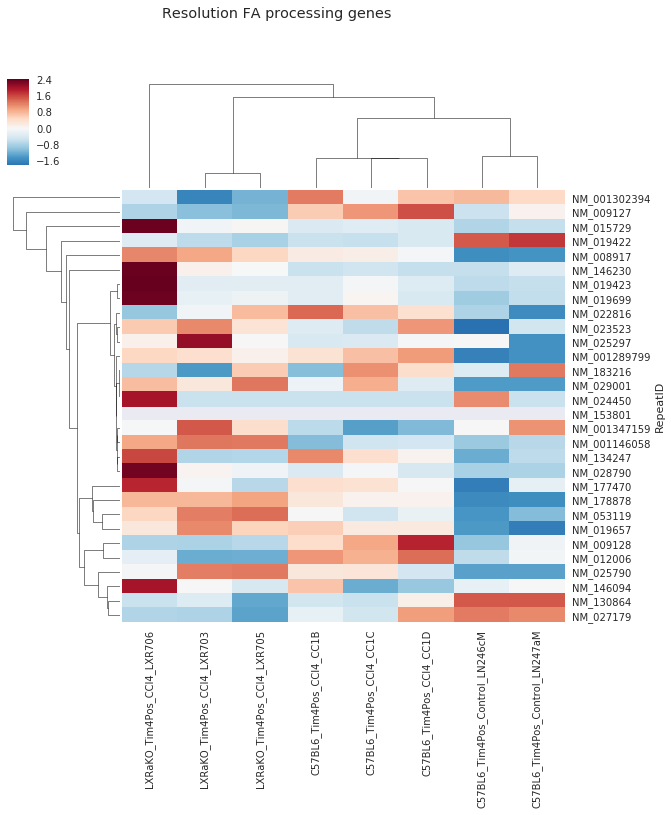

In [71]:
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
g = sns.clustermap(tpm_lipid_met.loc[:, list(subgroup)], z_score=0, cmap='RdBu_r', center=0,
                   row_linkage=row_link, col_linkage=col_link)
g.fig.suptitle('Resolution FA processing genes') 

KC specific genes

In [72]:
f = open('/home/h1bennet/data/gene_lists/mouse/KC_Specific_Genes150.txt')
kc_spec_genes = f.read().split()

# select genes so we can get refseq ids
subgroup = (((samplesDF.genotype=='C57BL6') & (samplesDF.diet=='Control')) | ((samplesDF.diet=='CCl4') & (samplesDF.cells=='Tim4Pos')))
kc_spec_genes_refseq = mm10_refseq.loc[mm10_refseq.gene.str.contains('|'.join(kc_spec_genes)), :]
tpm_kc_spec = tpm_mat.reindex(list(kc_spec_genes_refseq.index)).loc[:, list(subgroup)].dropna().drop_duplicates()
tpm_kc_spec = tpm_kc_spec.loc[(tpm_kc_spec != 0).sum(1) > 1, :]


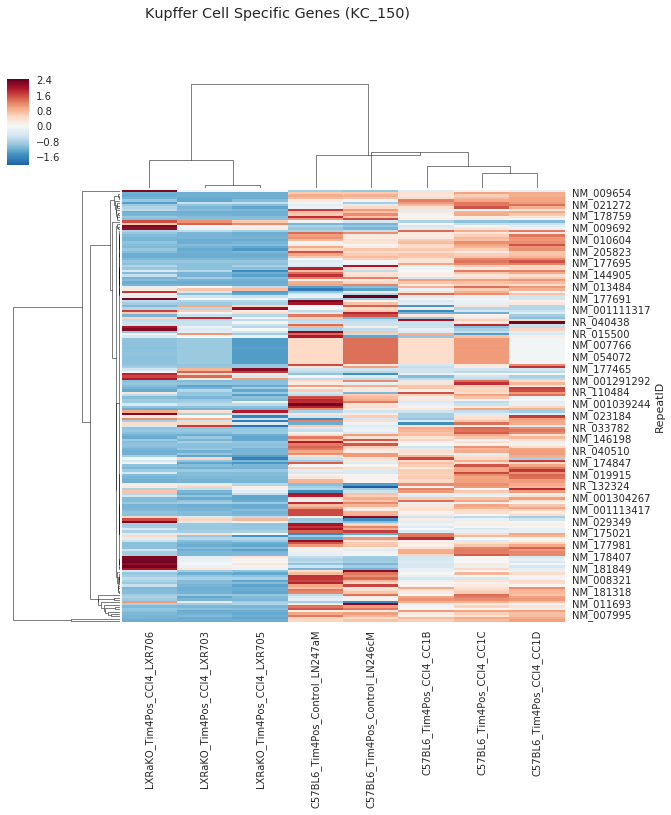

In [129]:
row_link = hierarchy.linkage(tpm_kc_spec, method='centroid')
col_link = hierarchy.linkage(tpm_kc_spec.T, method='centroid')
g = sns.clustermap(tpm_kc_spec, z_score=0, cmap='RdBu_r', center=0,
                   row_linkage=row_link, col_linkage=col_link)
g.fig.suptitle('Kupffer Cell Specific Genes (KC_150)')

### Violin Plot of KC Specific Genes

In [128]:
# subset tim4 positive cells
tim4pos = samplesDF.cells == 'Tim4Pos'
# select kupffer cell specific genes in tim4pos cells
tpm_tim4_pos_kc = tpm_mat.reindex(list(kc_spec_genes_refseq.index)).loc[:, list(tim4pos)].dropna().drop_duplicates()
tpm_tim4_pos_kc.columns = list(samplesDF.loc[tim4pos, 'group_diet'])
# melt data frame for plotting as violin
tpm_kc_spec_melt = tpm_tim4_pos_kc.T.reset_index().melt(id_vars='index', var_name = 'RepeatID')
# create log2 column for plotting
tpm_kc_spec_melt['log2tpm'] = np.log2(tpm_kc_spec_melt.value + 1)
# re-sort so that the index order is more useful
tpm_kc_spec_melt = tpm_kc_spec_melt.sort_values(by='index').reset_index(drop=True)

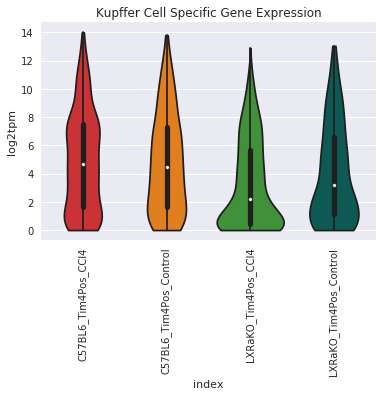

In [127]:
g = sns.violinplot(x='index', y='log2tpm', data=tpm_kc_spec_melt, palette=color_dict, cut=0)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Kupffer Cell Specific Gene Expression')

In [142]:
from scipy import stats
print(stats.ranksums(tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_CCl4', 'value'],
                     tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='C57BL6_Tim4Pos_CCl4', 'value']))
print(stats.ranksums(tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_Control', 'value'],
                     tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='C57BL6_Tim4Pos_Control', 'value']))
print(stats.ranksums(tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_CCl4', 'value'],
                     tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='LXRaKO_Tim4Pos_Control', 'value']))
print(stats.ranksums(tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='C57BL6_Tim4Pos_CCl4', 'value'],
                     tpm_kc_spec_melt.loc[tpm_kc_spec_melt.loc[:, 'index']=='C57BL6_Tim4Pos_Control', 'value']))

RanksumsResult(statistic=-8.0853528232034311, pvalue=6.1984490038955533e-16)
RanksumsResult(statistic=-3.210421286433772, pvalue=0.0013254056299723726)
RanksumsResult(statistic=-3.4590627773036018, pvalue=0.00054205854800412449)
RanksumsResult(statistic=0.39772620674149239, pvalue=0.6908320174935263)


In [197]:
tpm_kc_spec.loc['NM_007766', :]

C57BL6_Tim4Pos_CC1B       1.025412
C57BL6_Tim4Pos_CC1C       1.359284
C57BL6_Tim4Pos_CC1D       0.751311
LXRaKO_Tim4Pos_LXR703     0.288332
LXRaKO_Tim4Pos_LXR705     0.032183
LXRaKO_Tim4Pos_LXR706     0.240013
C57BL6_Tim4Pos_LN246cM    1.523290
C57BL6_Tim4Pos_LN247aM    1.058788
Name: NM_007766, dtype: float64

In [198]:
tpm_kc_spec.loc['NM_054072', :]

C57BL6_Tim4Pos_CC1B       1.038816
C57BL6_Tim4Pos_CC1C       1.376191
C57BL6_Tim4Pos_CC1D       0.761464
LXRaKO_Tim4Pos_LXR703     0.291536
LXRaKO_Tim4Pos_LXR705     0.035401
LXRaKO_Tim4Pos_LXR706     0.246680
C57BL6_Tim4Pos_LN246cM    1.545833
C57BL6_Tim4Pos_LN247aM    1.071982
Name: NM_054072, dtype: float64